# Resnet - Pytorch
This notebook shows how to compile Resnet/Pytorch to AWS Inferentia (inf1 instances) using NeuronSDK. We'll use pre-trained models (Imagenet) provided by torchvision.

**Reference:** https://pytorch.org/vision/stable/models/resnet.html

## 1) Install dependencies

In [ ]:
# Set Pip repository  to point to the Neuron repository
%pip config set global.extra-index-url https://pip.repos.neuron.amazonaws.com
# now restart the kernel

In [ ]:
#Install Neuron PyTorch
%pip install -U torch-neuron==1.10.1.2.2.0.0 neuron-cc[tensorflow] "protobuf<4" torchvision
# use --force-reinstall if you're facing some issues while loading the modules
# now restart the kernel again

## 2) Initialize libraries and prepare input samples
Select the desired number of layers for your Model

In [ ]:
import torch
import torch.neuron
import torchvision
from torchvision.io import read_image
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152

## Choose the network size
RESNET_SIZE=18 # can be 18,34,50,101,152
assert(RESNET_SIZE in [18,34,50,101,152])
IMAGE_SIZE=224 # this is the default for Imagenet

model_name=f"resnet{RESNET_SIZE}"
resnet = eval(model_name)

# dummy input data compatible with Imagenet(dataset)
x = torch.rand(1,3,224,224).float()

## 3) Load a pre-trained model and check if it is .jit traceable


In [ ]:
print(f'Loading a pre-trained Resnet{RESNET_SIZE}')
model = resnet(pretrained=True)
model.eval()
    
y = model(x) # warmup the model
try:
    traced_model = torch.jit.trace(model, x)
    print("Cool! Model is jit traceable")
except Exception as e:
    print("Ops. Something went wrong. Model is not traceable")
## ok the model is .jit traceable. now let's compile it with NeuronSDK

## 4) Analyze & compile the model for Inferentia with NeuronSDK

Neuron Check Model tool provides user with basic information about the compiled and uncompiled model’s operations without the use of TensorBoard-Neuron.  
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-tools/tutorial-neuron-check-model.html


The PyTorch-Neuron trace Python API provides a method to generate PyTorch models for execution on Inferentia, which can be serialized as TorchScript. It is analogous to torch.jit.trace() function in PyTorch.   
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-compilation-python-api.html?highlight=trace

In [ ]:
neuron_model = torch.neuron.trace(model, x)
neuron_model.save(f"neuron_{model_name}.pt")

In [ ]:
y = neuron_model(x) # warmup
%timeit neuron_model(x)

## 5) A simple test to check the predictions

Label: goldfish, Confidence: 0.9809226393699646
Label: axolotl, Confidence: 0.004267352633178234
Label: agama, Confidence: 0.004267352633178234
Label: newt, Confidence: 0.002932905685156584
Label: banded gecko, Confidence: 0.002755209803581238


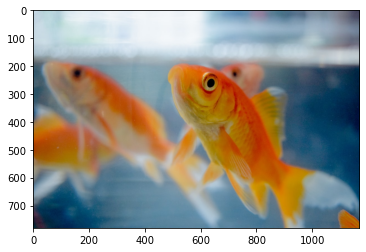

In [8]:
%matplotlib inline
import sys
if '..' not in sys.path: sys.path.append('..')
import cv2
import torch
import torch.neuron
import matplotlib.pyplot as plt
from common import processing

# load model
model_neuron = torch.load(f"neuron_{model_name}.pt")
# load a sample image
img = processing.load_sample_imgA()
# load the labels
labels = processing.load_imagenet1k_labels()

# pre-process image
x = processing.preprocess_imagenet(img)
x = torch.from_numpy(x)
# run the model on inferentia and get the predictions
y = model_neuron(x).softmax(dim=1)

# list the top5 classes
top_5 = (-y[0]).argsort()[:5]
for l in top_5: print(f'Label: {labels[l]}, Confidence: {y[0][l]}')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))